# Stock Price Predictor

The first step is to load the required modules to make the predictions we need.

In [1]:
%matplotlib notebook

import sys, os, pdb
import uuid, json, time
import pandas as pd

# import predictions algorithms
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

os.chdir(os.getcwd() + '/ml_api')
# import main stocks predictor / data preprocessing file
import lib.stocks as st
import lib.visualizer as vzr

#### Configurations & Parameters

Below we set the tickers we would like to train on and the dates for starting predictions.

In [2]:
DATE_TRAIN_START = '2015-01-01'
DATE_TEST_START = '2016-06-01'
DATE_END = '2016-09-01'

WINDOWS = [5]
HORIZONS = [7]

TICKERS_TRAIN = ['AMZN', 'AAPL', 'CSCO', 'NVDA', 'GOOG']
TICKERS_PREDICT = ['NVDA', 'GOOG', 'AMZN']

The next step is to create a directory where we will save the transformed data. This is done to avoid loading many data files in memeory since our algorithm may apply multiple windows and horizons (a file for each).

Once we've created a directory, we proceed to load a single data representing needed information about all the specified stocks __before__ transformation.

In [3]:
# create a directory with a unique ID
TRIAL_ID = uuid.uuid1()
DIRECTORY = 'trials/%s'%TRIAL_ID
os.makedirs(DIRECTORY)

print "Loading data for %s..."%', '.join(TICKERS_TRAIN)

data_files = st.loadMergedData(
    WINDOWS, HORIZONS, TICKERS_TRAIN, TICKERS_PREDICT,
    DATE_TRAIN_START, DATE_END, DIRECTORY
)

print "A new trial started with ID: %s\n"%TRIAL_ID
print "The data files generated are:"
print data_files

Loading data for AMZN, AAPL, CSCO, NVDA, GOOG...
A new trial started with ID: 48a2b17d-9ed3-11e6-b37a-3c075403b3fd

The data files generated are:
[(7, 5, 'trials/48a2b17d-9ed3-11e6-b37a-3c075403b3fd/finance_w7_h5.csv')]


Now we create a list of regressors which we would like to use for making predictions:

In [4]:
classifiers = [
    ('GradientBoosted', MultiOutputRegressor(GradientBoostingRegressor())),
    # ('AdaBoost', MultiOutputRegressor(AdaBoostRegressor()))
]

Starting an iteration with a horizon of 7 and a window of 5...
Training and testing the GradientBoosted model...

Below is a sample of of the results:



,adj_close_AMZN_pred,adj_close_AMZN_true,adj_close_GOOG_pred,adj_close_GOOG_true,adj_close_NVDA_pred,adj_close_NVDA_true
Date,,,,,,
2016-06-04,598.128353,602.08,742.664926,745.69,35.319093,35.644309
2016-07-04,593.534190,591.43,741.500746,740.28,35.245581,35.275918
2016-07-27,745.761629,736.67,740.075551,741.77,54.645438,55.957709
2016-08-06,718.264775,726.64,727.623994,728.28,47.787265,46.095737
2016-08-18,757.335446,764.46,778.134141,777.50,57.818193,61.986688
2016-08-24,759.443109,757.25,769.451819,769.64,58.614088,61.940000
2016-08-29,765.652153,771.29,769.713618,772.15,59.163228,61.990000
2016-10-08,765.459977,768.56,779.032919,784.68,58.121734,58.403238
2016-11-04,594.902809,595.93,738.712894,736.10,36.034562,35.723961


<IPython.core.display.Javascript object>


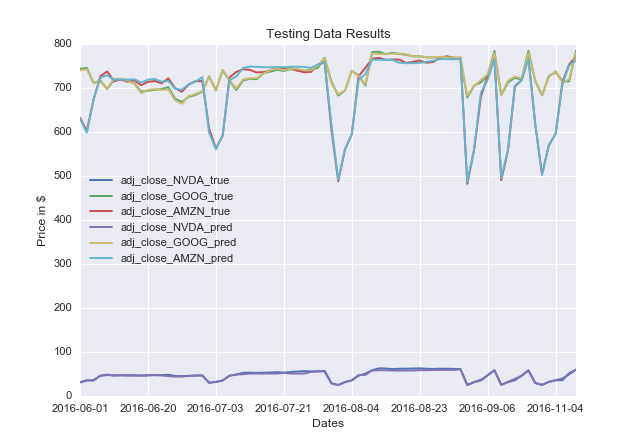

{
    "H7_W5": {
        "accuracy_GradientBoosted": 1.3127496180392006, 
        "time_lapsed": 4.402709007263184, 
        "window": 5, 
        "cross_validation_GradientBoosted": 1.677, 
        "horizon": 7
    }
}


In [5]:
from IPython.display import display

# - combine the results of each classifier along with its w + h into a response object
all_results = {}

# - train each of the models on the data and save the highest performing
#         model as a pickle file
for h, w, file_path in data_files:
    # Start measuing time
    time_start = time.time()
    
    # load data
    finance = pd.read_csv(file_path, encoding='utf-8', header=0)
    finance = finance.set_index(finance.columns[0])
    finance.index.name = 'Date'
    
    # perform preprocessing
    X_train, y_train, X_test, y_test = \
        st.prepareDataForClassification(finance, DATE_TEST_START, TICKERS_PREDICT, h, w)

    results = {}

    print "Starting an iteration with a horizon of {} and a window of {}...".format(h, w)

    for i, clf_ in enumerate(classifiers):
        print "Training and testing the %s model..."%(clf_[0])
        
        # perform k-fold cross validation
        results['cross_validation_%s'%clf_[0]] = \
            st.performCV(X_train, y_train, 10, clf_[1], clf_[0])
        
        # perform predictions with testing data and record result
        preds, results['accuracy_%s'%clf_[0]] = \
            st.trainPredictStocks(X_train, y_train, X_test, y_test, clf_[1], DIRECTORY)

        print "\nBelow is a sample of of the results:\n"
        display(preds.sample(10).sort_index().reindex_axis(sorted(preds.columns), axis=1))
            
        # plot results
        vzr.visualize_predictions(preds, title='Testing Data Results')

    results['window'] = w
    results['horizon'] = h

    # Stop time counter
    time_end = time.time()
    results['time_lapsed'] = time_end - time_start

    all_results['H%s_W%s'%(h, w)] = results

print json.dumps(all_results, indent=4)